# Tracking through elements with autodiff

In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
from pytao import Tao
import matplotlib.pyplot as plt
import numdifftools as nd
from bmadx import track
tkwargs = {
    "dtype" : torch.double
}
import time
import os
np.set_printoptions(precision= 15, suppress=False)
torch.set_printoptions(precision= 15, sci_mode=True)
import pytao
torch.__version__, np.__version__, pytao.__version__

('1.11.0', '1.22.4', '0.1.7')

In [2]:
from pathlib import Path

def find_repo(path):
    "Find repository root from the path's parents"
    for path in Path(path).parents:
        # Check whether "path/.git" exists and is a directory
        git_dir = path / ".git"
        if git_dir.is_dir():
            return path

import os
nb_dir = os.getcwd()
# Find the repo root where the script is
repo_path = str(find_repo(nb_dir))
repo_path

'/home/jg2347/Repositories/Bmad-X'

# Constants

In [3]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

# Drift tests

In [4]:
# Create drift
L=1.0 # Drift length in m
d1 = track.Drift(L=torch.tensor(L, **tkwargs)) #named tuple is in track.py module
d1

Drift(L=tensor(1.000000000000000e+00, dtype=torch.float64))

## Drift one particle test

In [5]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = track.Particle(*tvec1,ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.109989500000000e+05, dtype=torch.float64))

In [6]:
#create track_a_drift_torch
track_a_drift_torch = track.make_track_a_drift(torch)
# Outgoing particle
p_out = track_a_drift_torch(p_in, d1)
x_py = torch.hstack([p_out.x,p_out.px,p_out.y,p_out.py,p_out.z,p_out.pz]).detach()
x_py

tensor([5.006027114522933e-03, 3.000000000000000e-03, -4.002009038174311e-03,
        -1.000000000000000e-03, 1.994652573892362e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [7]:
# bmad lattice for comparison
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_drift.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out=tao.orbit_at_s(ele=1)
#orbit_out

In [8]:
# bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([5.006027114522930e-03, 3.000000000000000e-03, -4.002009038174310e-03,
        -1.000000000000000e-03, 1.994652573892360e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [9]:
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Drift Jacobian test

In [10]:
# autodiff Jacobian matrix
f_drift = lambda x: track_a_drift_torch(track.Particle(*x, ts, tp0c, tmc2), d1)[:6]
J = jacobian(f_drift, tvec1)
mat_py = torch.vstack(J)
mat_py

tensor([[ 1.000000000000000e+00,  1.002018092527393e+00,  0.000000000000000e+00,
         -3.018117694005117e-06,  0.000000000000000e+00, -3.012081458617107e-03],
        [ 0.000000000000000e+00,  1.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [ 0.000000000000000e+00, -3.018117694005117e-06,  1.000000000000000e+00,
          1.002010044213542e+00,  0.000000000000000e+00,  1.004027152872369e-03],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          1.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [ 0.000000000000000e+00, -3.012081458617106e-03,  0.000000000000000e+00,
          1.004027152872369e-03,  1.000000000000000e+00,  1.742165247481025e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [11]:
# Bmad formula Jacobian
drift_tao = tao.matrix(0,1)
mat_tao = torch.tensor(drift_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.000000000000000e+00,  1.002018092527390e+00,  0.000000000000000e+00,
         -3.018117694005120e-06,  0.000000000000000e+00, -3.012081458617110e-03],
        [ 0.000000000000000e+00,  1.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [ 0.000000000000000e+00, -3.018117694005120e-06,  1.000000000000000e+00,
          1.002010044213540e+00,  0.000000000000000e+00,  1.004027152872370e-03],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          1.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [ 0.000000000000000e+00, -3.012081458617110e-03,  0.000000000000000e+00,
          1.004027152872370e-03,  1.000000000000000e+00,  1.742165247481030e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [12]:
# is it close to Tao result?
torch.allclose(mat_py, mat_tao, atol=0, rtol=1.0e-14)

True

# Quadrupole tests

In [13]:
def torch_quadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                     X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                     Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                     TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return track.Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                            Y_OFFSET=Y_OFFSET, TILT=TILT)

In [14]:
# Create quad
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x
#NUM_STEPS = 1 #number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
q1

Quadrupole(L=tensor(1.000000000000000e-01, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64))

## Quadrupole one particle test

In [15]:
# create track_a_quadrupole_torch
track_a_quadrupole_torch = track.make_track_a_quadrupole(torch)
# Outgoing particle
p_out = track_a_quadrupole_torch(p_in, q1)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.196239719302552e-03, 8.841834264853368e-04, -3.253441973269224e-03,
        -4.100871741572859e-03, 1.999394664225331e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [16]:
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

In [17]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.196239719302550e-03, 8.841834264853370e-04, -3.253441973269220e-03,
        -4.100871741572860e-03, 1.999394664225330e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [18]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Quadrupole Jacobian test

In [19]:
# autodiff Jacobian matrix
f_quadrupole = lambda x: track_a_quadrupole_torch(track.Particle(*x,ts, tp0c, tmc2), q1)[:6]
J = jacobian(f_quadrupole, tvec1)
mat_py = torch.vstack(J)
mat_py

tensor([[ 9.503167431875498e-01,  9.853541097581728e-02,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00, -1.924858550317723e-04],
        [-9.833834015386563e-01,  9.503167431875498e-01, -0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.149663908944082e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  1.050519938506054e+00,
          1.018821577510623e-01,  0.000000000000000e+00,  2.569093937337833e-04],
        [-0.000000000000000e+00,  0.000000000000000e+00,  1.016783934355602e+00,
          1.050519938506054e+00,  0.000000000000000e+00,  1.017485822657404e-04],
        [ 8.003290869842023e-05, -1.942507914386516e-04,  1.543324297486644e-04,
          2.595220753974964e-04,  1.000000000000000e+00,  1.756709202142694e-05],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [20]:
# Bmad formula Jacobian
quad_tao = tao.matrix(0,1)
mat_tao = torch.tensor(quad_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 9.503167431875500e-01,  9.853541097581731e-02,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00, -1.924858550317720e-04],
        [-9.833834015386560e-01,  9.503167431875500e-01,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.149663908944080e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  1.050519938506050e+00,
          1.018821577510620e-01,  0.000000000000000e+00,  2.569093937337830e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  1.016783934355600e+00,
          1.050519938506050e+00,  0.000000000000000e+00,  1.017485822657410e-04],
        [ 8.003290869842020e-05, -1.942507914386520e-04,  1.543324297486640e-04,
          2.595220753974960e-04,  1.000000000000000e+00,  1.756709202142690e-05],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [21]:
# close to Tao result?
torch.allclose(mat_py, mat_tao, atol=0, rtol=1.0e-14)

True

## Quadrupole offset test

In [22]:
# Quad params
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x

# quad w/o offsets
q_no_off = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
# quad with offsets
x_off = 1e-3
y_off = -2e-3
q_off = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs), 
                         X_OFFSET=torch.tensor(x_off, **tkwargs),
                         Y_OFFSET=torch.tensor(y_off, **tkwargs) )

In [23]:
# Outgoing particle no offset
p_out = track_a_quadrupole_torch(p_in, q_no_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.196239719302552e-03, 8.841834264853368e-04, -3.253441973269224e-03,
        -4.100871741572859e-03, 1.999394664225331e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [24]:
# Outgoing particle offset
p_out = track_a_quadrupole_torch(p_in, q_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.245922976115002e-03, 1.867566828023993e-03, -3.152402096257116e-03,
        -2.067303872861656e-03, 1.999538606428305e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [25]:
%%time
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_quad_offset.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

CPU times: user 20.8 ms, sys: 2.52 ms, total: 23.3 ms
Wall time: 26 ms


In [26]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.245922976115000e-03, 1.867566828023990e-03, -3.152402096257120e-03,
        -2.067303872861660e-03, 1.999538606428300e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [27]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Quadrupole tilt test (transverse rotation)

In [28]:
# Quad params
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x

# quad w/o tilt
q_no_tilt = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
# quad with tilt
tilt = 0.3
q_tilt = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs),
                          TILT = torch.tensor(tilt, **tkwargs))

In [29]:
# Outgoing particle no tilt
p_out = track_a_quadrupole_torch(p_in, q_no_tilt)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.196239719302552e-03, 8.841834264853368e-04, -3.253441973269224e-03,
        -4.100871741572859e-03, 1.999394664225331e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [30]:
# Outgoing particle tilt
p_out = track_a_quadrupole_torch(track.Particle(*tvec1,ts, tp0c, tmc2), q_tilt)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.300431812756860e-03, 2.982152956166943e-03, -3.286310353406088e-03,
        -4.782331681936468e-03, 1.999046404985869e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [31]:
%%time
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_quad_tilt.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

CPU times: user 26.9 ms, sys: 3.97 ms, total: 30.9 ms
Wall time: 31 ms


In [32]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.300431812756860e-03, 2.982152956166940e-03, -3.286310353406090e-03,
        -4.782331681936470e-03, 1.999046404985870e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [33]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

# Crab_Cavity tests

In [34]:
def torch_crab_cavity(L: torch.Tensor, VOLTAGE: torch.Tensor,
                      PHI0: torch.Tensor, RF_FREQUENCY: torch.Tensor,
                      X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                      Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                      TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return track.CrabCavity(L=L, VOLTAGE=VOLTAGE, PHI0=PHI0,
                            RF_FREQUENCY=RF_FREQUENCY, X_OFFSET=X_OFFSET,
                            Y_OFFSET=Y_OFFSET, TILT=TILT)

In [35]:
# Create cavity
L = 0.2
voltage = 1.0e4
phi0 = 0.5
rf = 1.0e9
cav = torch_crab_cavity(L=torch.tensor(L, **tkwargs),
                        VOLTAGE=torch.tensor(voltage, **tkwargs),
                        PHI0=torch.tensor(phi0, **tkwargs),
                        RF_FREQUENCY=torch.tensor(rf, **tkwargs))
cav

CrabCavity(L=tensor(2.000000000000000e-01, dtype=torch.float64), VOLTAGE=tensor(1.000000000000000e+04, dtype=torch.float64), PHI0=tensor(5.000000000000000e-01, dtype=torch.float64), RF_FREQUENCY=tensor(1.000000000000000e+09, dtype=torch.float64), X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64))

## Crab_cavity one particle test

In [36]:
# create track_a_crab_cavity_torch
track_a_crab_cavity_torch = track.make_track_a_crab_cavity(torch)
# Outgoing particle
p_out = track_a_crab_cavity_torch(p_in, cav)
#p_out
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.600159503009856e-03, 2.989525785200116e-03, -3.200403013811110e-03,
        -1.000000000000000e-03, 1.998933450470348e-03, -2.012044669173099e-03],
       dtype=torch.float64)

In [37]:
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_crab_cavity.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

In [38]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.600159503009860e-03, 2.989525785200120e-03, -3.200403013811110e-03,
        -1.000000000000000e-03, 1.998933450470350e-03, -2.012044669173100e-03],
       dtype=torch.float64)

In [39]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Crab_cavity Jacobian test

In [40]:
# autodiff Jacobian matrix
f_crab_cavity = lambda x: track_a_crab_cavity_torch(track.Particle(*x,ts, tp0c, tmc2), cav)[:6]
J = jacobian(f_crab_cavity, tvec1)
mat_py = torch.vstack(J)
mat_py

tensor([[ 1.000001571489388e+00,  2.004051338856653e-01,  0.000000000000000e+00,
         -6.552534052264527e-07, -5.246100940167111e-04, -6.013813103820471e-04],
        [ 0.000000000000000e+00,  1.000001576957398e+00,  0.000000000000000e+00,
         -5.256524659788450e-07, -5.235440739575950e-03, -8.949162872176157e-08],
        [-5.256651057680826e-07, -6.552540421507948e-07,  1.000000000000000e+00,
          2.004032150230133e-01,  2.637597029868803e-09,  2.008080032283205e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          1.000000000000000e+00, -0.000000000000000e+00,  0.000000000000000e+00],
        [-9.289874897604998e-08, -6.013816504874850e-04, -0.000000000000000e+00,
          2.008080022802770e-04,  1.000001569699991e+00,  3.483769060576969e-05],
        [-5.235440749927688e-03, -5.246038241196926e-04, -0.000000000000000e+00,
          2.643031443043208e-09,  1.058650459477272e-05,  1.000001579115604e+00]],
       dtype=torch.fl

In [41]:
# Bmad formula Jacobian
cav_tao = tao.matrix(0,1)
mat_tao = torch.tensor(cav_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.000001571489390e+00,  2.004051338856650e-01,  0.000000000000000e+00,
         -6.552534052264531e-07, -5.246100940167110e-04, -6.013813103820470e-04],
        [ 0.000000000000000e+00,  1.000001576957400e+00,  0.000000000000000e+00,
         -5.256524659788450e-07, -5.235440739575950e-03, -8.949162872175810e-08],
        [-5.256651057680830e-07, -6.552540421507950e-07,  1.000000000000000e+00,
          2.004032150230130e-01,  2.637597029868800e-09,  2.008080032283200e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          1.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [-9.289874897604990e-08, -6.013816504874850e-04,  0.000000000000000e+00,
          2.008080022802770e-04,  1.000001569699990e+00,  3.483769060576920e-05],
        [-5.235440749927690e-03, -5.246038241196930e-04,  0.000000000000000e+00,
          2.643031443043210e-09,  1.058650459477270e-05,  1.000001579115600e+00]],
       dtype=torch.fl

In [42]:
# close to Tao result up to 13th decimal place
torch.allclose(mat_py, mat_tao, atol=0, rtol=1.0e-13)

True

In [43]:
# but not up to 14th decimal place
torch.isclose(mat_py, mat_tao, atol=0, rtol=1e-14)

tensor([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True]])

## Crab_cavity offset test

In [44]:
# Cavity params
L = 0.2
voltage = 1.0e3
phi0 = 0.5
rf = 1.0e9

# cav w/o offsets
cav_no_off = torch_crab_cavity(L=torch.tensor(L, **tkwargs),
                               VOLTAGE=torch.tensor(voltage, **tkwargs),
                               PHI0=torch.tensor(phi0, **tkwargs),
                               RF_FREQUENCY=torch.tensor(rf, **tkwargs))

#cav with offsets
x_off = 1e-3
y_off = -2e-3
cav_off = torch_crab_cavity(L=torch.tensor(L, **tkwargs),
                            VOLTAGE=torch.tensor(voltage, **tkwargs),
                            PHI0=torch.tensor(phi0, **tkwargs),
                            RF_FREQUENCY=torch.tensor(rf, **tkwargs),
                            X_OFFSET=torch.tensor(x_off, **tkwargs),
                            Y_OFFSET=torch.tensor(y_off, **tkwargs))

In [45]:
# Outgoing particle no offset
p_out = track_a_crab_cavity_torch(p_in, cav_no_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.601100832046753e-03, 2.998952578520011e-03, -3.200401928250687e-03,
        -1.000000000000000e-03, 1.998930808836860e-03, -2.001204466916434e-03],
       dtype=torch.float64)

In [46]:
# Outgoing particle offset
p_out = track_a_crab_cavity_torch(track.Particle(*tvec1,ts, tp0c, tmc2), cav_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.601100674405775e-03, 2.998952578520011e-03, -3.200401875685341e-03,
        -1.000000000000000e-03, 1.998930818129399e-03, -2.000680922842398e-03],
       dtype=torch.float64)

In [47]:
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_crab_cavity_offset.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

In [48]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.601100674405770e-03, 2.998952578520010e-03, -3.200401875685340e-03,
        -1.000000000000000e-03, 1.998930818129400e-03, -2.000680922842400e-03],
       dtype=torch.float64)

In [49]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Crab_cavity tilt test

In [50]:
# Cavity params
L = 0.2 #Length in m
voltage = 1.0e3 #Quad focusing strength. Positive is focusing in x
phi0 = 0.5
rf = 1.0e9

# cav w/o tilt
cav_no_tilt = torch_crab_cavity(L=torch.tensor(L, **tkwargs),
                                VOLTAGE=torch.tensor(voltage, **tkwargs),
                                PHI0=torch.tensor(phi0, **tkwargs),
                                RF_FREQUENCY=torch.tensor(rf, **tkwargs))

#cav with tilt
x_off = 1e-3
y_off = -2e-3
tilt = 0.3
cav_tilt = torch_crab_cavity(L=torch.tensor(L, **tkwargs),
                             VOLTAGE=torch.tensor(voltage, **tkwargs),
                             PHI0=torch.tensor(phi0, **tkwargs),
                             RF_FREQUENCY=torch.tensor(rf, **tkwargs),
                             TILT=torch.tensor(tilt, **tkwargs))

In [51]:
# Outgoing particle no offset
p_out = track_a_crab_cavity_torch(p_in, cav_no_tilt)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.601100832046753e-03, 2.998952578520011e-03, -3.200401928250687e-03,
        -1.000000000000000e-03, 1.998930808836860e-03, -2.001204466916434e-03],
       dtype=torch.float64)

In [52]:
# Outgoing particle offset and tilt
p_out = track_a_crab_cavity_torch(track.Particle(*tvec1,ts, tp0c, tmc2), cav_tilt)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.601105359111942e-03, 2.998999360040673e-03, -3.200432890364399e-03,
        -1.000309534212228e-03, 1.998930773136149e-03, -2.000671014767513e-03],
       dtype=torch.float64)

In [53]:
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_crab_cavity_tilt.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

In [54]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.601105359111940e-03, 2.998999360040670e-03, -3.200432890364400e-03,
        -1.000309534212230e-03, 1.998930773136150e-03, -2.000671014767510e-03],
       dtype=torch.float64)

In [55]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

In [56]:
f_crab_cavity = lambda x: track_a_crab_cavity_torch(track.Particle(*x,ts, tp0c, tmc2), cav_tilt)[:6]
J = jacobian(f_crab_cavity, tvec1)
mat_py = torch.vstack(J)
mat_py

tensor([[ 1.000000150602446e+00,  2.004037151906528e-01,  4.658679586544423e-08,
         -6.039807690927379e-07, -5.011717697334090e-05, -6.023171246175704e-04],
        [ 0.000000000000000e+00,  1.000000150652494e+00,  0.000000000000000e+00,
         -5.021749810429910e-08, -5.001607575171654e-04, -8.549461838918098e-09],
        [-5.023310933882641e-08, -6.039807756291760e-07,  9.999999844610783e-01,
          2.004020728926290e-01, -1.550268447215676e-05,  2.008363914804506e-04],
        [ 0.000000000000000e+00,  4.660227759245572e-08,  0.000000000000000e+00,
          9.999999844659074e-01, -1.547178529322681e-04, -2.644658461431463e-09],
        [-8.877538963465590e-09, -6.023171574216554e-04, -2.746144608721748e-09,
          2.008363812799022e-04,  1.000000134963841e+00,  3.484280382627325e-05],
        [-5.001607575722588e-04, -5.011714377673051e-05, -1.547178529493105e-04,
         -1.550267409755359e-05,  5.897796618608915e-07,  1.000000135238635e+00]],
       dtype=torch.fl

In [57]:
cav_tao = tao.matrix(0,1)
mat_tao = torch.tensor(cav_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.000000150602450e+00,  2.004037151906530e-01,  4.658679586544420e-08,
         -6.039807690857990e-07, -5.011717697334090e-05, -6.023171246175700e-04],
        [ 0.000000000000000e+00,  1.000000150652490e+00,  0.000000000000000e+00,
         -5.021749810429910e-08, -5.001607575171650e-04, -8.549461838917659e-09],
        [-5.023310933882640e-08, -6.039807756222370e-07,  9.999999844610780e-01,
          2.004020728926290e-01, -1.550268447215680e-05,  2.008363914804510e-04],
        [ 0.000000000000000e+00,  4.660227764796690e-08,  0.000000000000000e+00,
          9.999999844659070e-01, -1.547178529322680e-04, -2.644658461431380e-09],
        [-8.877538963465760e-09, -6.023171574216550e-04, -2.746144608721800e-09,
          2.008363812799020e-04,  1.000000134963840e+00,  3.484280382627260e-05],
        [-5.001607575722590e-04, -5.011714377673050e-05, -1.547178529493100e-04,
         -1.550267409755360e-05,  5.897796618608910e-07,  1.000000135238630e+00]],
       dtype=torch.fl

In [58]:
torch.isclose(mat_py, mat_tao, atol=0, rtol=1.0e-10)

tensor([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]])

In [ ]:
# Something is wrong with the Jacobian matrix of a tilted cavity. Currently debuging.

# Lattice tracking

## Lattice one particle test

In [59]:
# Create drift
L_d = 1.0 # Drift length in m
d1 = track.Drift(torch.tensor(L_d, **tkwargs))
# Create quad
L_q = 0.1  # quad length in m
K1 = 10  # Quad focusing strength. Positive is focusing in x
#NUM_STEPS = 1  # number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = torch_quadrupole(L=torch.tensor(L_q, **tkwargs), K1=torch.tensor(K1, **tkwargs))

In [60]:
# Lattice example
lattice = [d1, q1, d1, q1, d1]  # lattice is a list of elements
# List of particle coordinates after each element:
x_list = [torch.hstack(coords[:6]).detach() for coords in track.track_a_lattice(p_in, lattice)]
# Outgoing particle after complete lattice:
x_py = torch.hstack(track.track_a_lattice(p_in, lattice)[-1][:6]).detach()
# alternative: x_list[-1]
x_py

tensor([-2.281967961209991e-03, -4.896330349656308e-03, -2.543913165908659e-02,
        -1.497282967847466e-02, 1.847324681974169e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [61]:
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_drift_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=5)

In [62]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([-2.281967961209990e-03, -4.896330349656310e-03, -2.543913165908660e-02,
        -1.497282967847470e-02, 1.847324681974170e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [63]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Lattice Jacobian test

In [64]:
f_driftquadrupole = lambda x: track.track_a_lattice(track.Particle(*x, ts, tp0c, tmc2), lattice)[-1][:6]
J = jacobian(f_driftquadrupole, tvec1)

In [65]:
# autodiff Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[-1.032202390317458e+00, -7.256968115101181e-02,  2.336717479636538e-04,
          4.049003895819779e-04,  0.000000000000000e+00,  8.218283945153969e-03],
        [-9.000515317112638e-01, -1.032080978292848e+00, -1.067067115329933e-05,
         -1.900037293643618e-05,  0.000000000000000e+00,  5.547564231500580e-04],
        [-8.812732879846703e-05, -9.339294371369415e-05,  5.457258390307320e+00,
          9.071019578396722e+00,  0.000000000000000e+00,  3.361265895544615e-02],
        [-1.067067115329933e-05, -9.954618543668099e-06,  3.172268131080336e+00,
          5.456165751278677e+00,  0.000000000000000e+00,  9.391470418309955e-03],
        [-6.823789171283308e-03, -8.441133541388406e-03,  5.537646874208031e-02,
          9.820564579614072e-02,  1.000000000000000e+00,  9.919963196451456e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [66]:
# Bmad formula Jacobian
lat_tao = tao.matrix(0,5)
mat_tao = torch.tensor(lat_tao['mat6'], **tkwargs)
mat_tao

tensor([[-1.032202390317460e+00, -7.256968115101139e-02,  2.336717479636540e-04,
          4.049003895819780e-04,  0.000000000000000e+00,  8.218283945153960e-03],
        [-9.000515317112640e-01, -1.032080978292850e+00, -1.067067115329930e-05,
         -1.900037293643620e-05,  0.000000000000000e+00,  5.547564231500580e-04],
        [-8.812732879846700e-05, -9.339294371369409e-05,  5.457258390307320e+00,
          9.071019578396720e+00,  0.000000000000000e+00,  3.361265895544610e-02],
        [-1.067067115329930e-05, -9.954618543668099e-06,  3.172268131080340e+00,
          5.456165751278680e+00,  0.000000000000000e+00,  9.391470418309950e-03],
        [-6.823789171283310e-03, -8.441133541388410e-03,  5.537646874208030e-02,
          9.820564579614070e-02,  1.000000000000000e+00,  9.919963196451461e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [67]:
# close to Tao result?
torch.allclose(mat_py, mat_tao, atol=0, rtol=1.0e-14)

True

## Multi-particle propagation through lattice

In [68]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
bunch_in = track.Particle(*sample.T, ts, tp0c, tmc2)

In [69]:
bunch_out = track.track_a_lattice(bunch_in, lattice)

In [70]:
# some beam properties up and downstream
torch.std(bunch_out[0].y),torch.std(bunch_out[-1].y)

(tensor(1.011633328777304e-03, dtype=torch.float64),
 tensor(1.414081080791480e-02, dtype=torch.float64))

## Stub element test

In [71]:
# divide a quad into 10 parts
divided_quad = track.stub_element(q1, 10)
divided_quad

[Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor

## Plotting using stub_element

In [72]:
# make a quadrupole triplet
L_d = 1.5  # Drift length in m
d1 = track.Drift(torch.tensor(L_d, **tkwargs)) # drift
L_q = 0.1  # Quadrupole length in m
K1 = 10  # Quadrupole strengths
NUM_STEPS = 1
q1 = torch_quadrupole(L=torch.tensor(L_q,**tkwargs), K1=torch.tensor(K1, **tkwargs))  # x-focusing
q2 = torch_quadrupole(L=torch.tensor(L_q,**tkwargs), K1=torch.tensor(-K1, **tkwargs))  # y-focusing
lattice = [d1, q1, d1, q2, d1, q1, d1]

# stub each element into n equal parts each
n=50
stubbed_lattice = track.stub_lattice(lattice, n)

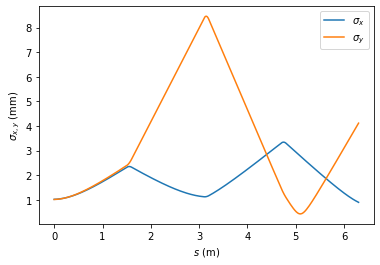

In [73]:
all_p = track.track_a_lattice(bunch_in, stubbed_lattice)
stdx = np.array([torch.std(par.x).item() for par in all_p])
stdy = np.array([torch.std(par.y).item() for par in all_p])
s = np.array([par.s.item() for par in all_p])
plt.plot(s, stdx*1000, label=r'$\sigma_x$')
plt.plot(s, stdy*1000, label=r'$\sigma_y$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

# Hessian Matrix example

In [74]:
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = track.Drift(torch.tensor(L_d, **tkwargs))

def sigmax_end(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(torch_quadrupole(L=torch.tensor(L_q, **tkwargs), K1=k1))
        lattice.append(drift)

    bunch_out = track.track_a_lattice(bunch_in, lattice)[-1]
    return torch.std(bunch_out.x)

#k1s = torch.tensor([10,-10,10,-10,10,-10,10,-10,10,-10], **tkwargs)
k1s = torch.zeros(10, **tkwargs)

In [75]:
#Hessian using autodiff
%time
hessian_py = hessian(sigmax_end,k1s)
hessian_py

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 20 µs


tensor([[6.212722493314672e-05, 1.934909455998306e-04, 3.066720792957840e-04,
         3.857407047937862e-04, 4.306968220938372e-04, 4.415404311959368e-04,
         4.182715321000853e-04, 3.608901248062825e-04, 2.693962093145284e-04,
         1.437897856248231e-04],
        [1.934909455998307e-04, 4.067402333702379e-05, 2.895403741702237e-04,
         4.968098212449029e-04, 6.334830314468892e-04, 6.995600047761827e-04,
         6.950407412327836e-04, 6.199252408166916e-04, 4.742135035279069e-04,
         2.579055293664292e-04],
        [3.066720792957842e-04, 2.895403741702237e-04, 2.533088433858130e-05,
         3.580817001946583e-04, 6.225518452007195e-04, 7.799674148994005e-04,
         8.303284092907017e-04, 7.736348283746227e-04, 6.098866721511639e-04,
         3.390839406203249e-04],
        [3.857407047937864e-04, 4.968098212449028e-04, 3.580817001946582e-04,
         1.480997689984993e-05, 3.979032633553279e-04, 6.827626615655902e-04,
         8.241345362738396e-04, 8.220188874

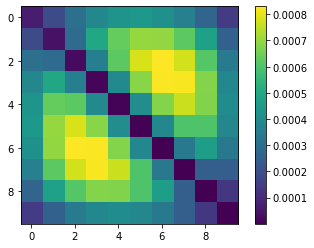

In [76]:
plt.imshow(hessian_py.detach().numpy())
plt.colorbar()
#plt.savefig("hessian.eps")

In [77]:
#Hessian using numerical differentiation

bunch_in_np = track.Particle(*sample.detach().numpy().T, 0, p0c, mc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = track.Drift(L_d)
def sigmax_end2(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(track.Quadrupole(L=L_q, K1=k1))
        lattice.append(drift)

    bunch_out = track.track_a_lattice(bunch_in_np, lattice)[-1]
    
    return np.std(bunch_out.x)

#k1s = np.array([10,-10,10,-10,10,-10,10,-10,10,-10])
k1s = np.zeros(10)

In [78]:
%time
hessian_nd = nd.Hessian(sigmax_end2)(k1s)
hessian_nd

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 22.2 µs


array([[6.754241373633320e-05, 2.157633338818432e-04,
        3.338224477200666e-04, 4.161395156427983e-04,
        4.627145376510163e-04, 4.735475137452001e-04,
        4.486384439334525e-04, 3.879873281929433e-04,
        2.915941665451957e-04, 1.594589589838871e-04],
       [2.157633338818432e-04, 5.045391339946996e-05,
        3.231806722480164e-04, 5.336344342343021e-04,
        6.718806680604759e-04, 7.379193737168628e-04,
        7.317505512165344e-04, 6.533742005587473e-04,
        5.027903217392661e-04, 2.799989147589356e-04],
       [3.338224477200666e-04, 3.231806722480164e-04,
        3.837469472217219e-05, 3.998104786083180e-04,
        6.657897217229806e-04, 8.231213319623739e-04,
        8.718053093358184e-04, 8.118416538447339e-04,
        6.432303654934769e-04, 3.659714442811151e-04],
       [4.161395156427983e-04, 5.336344342343021e-04,
        3.998104786083180e-04, 3.001757071018254e-05,
        4.444416986445159e-04, 7.291533884688072e-04,
        8.688027183011521

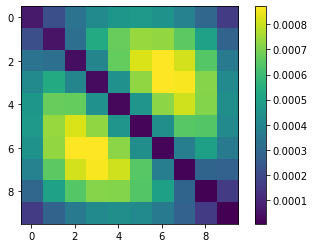

In [79]:
plt.imshow(hessian_nd)
plt.colorbar()

In [80]:
np.allclose(hessian_nd, hessian_py.detach().numpy())

False

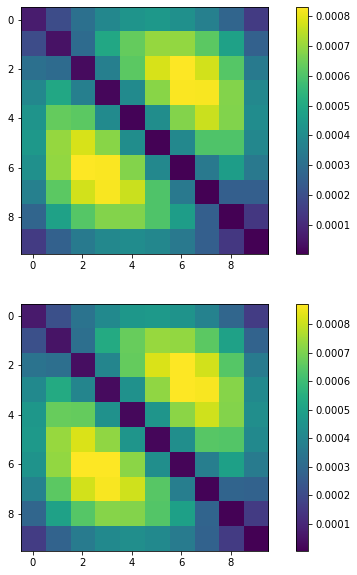

In [81]:
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hessian_py.detach().numpy())
fig.colorbar(cm,ax=axs[0])
#ax.imshow(hessian_py.detach().numpy())
#ax = axs[1]
#ax.imshow(1-hessian_nd)
cm = axs[1].imshow(hessian_nd)
fig.colorbar(cm,ax=axs[1])